# Code to look at predictions

In [7]:
import numpy as np
import torch
import matplotlib
import seaborn as sns; sns.set()
from matplotlib import colors
from matplotlib import pyplot as plt
device = "cpu"
%matplotlib notebook

# Define nonlinear activation function
def f(x): # nonlinear conversion function to binary
    return x.sigmoid()#tanh().add(1).div(2)

In [2]:
# lists of parameters
Rs = [0.0, 0.25, 0.3, 0.4, 0.5, 0.6, 0.7, 0.75, 0.8, 0.85, 0.9, 1.0]
Rs = [0.0, 0.25, 0.5, 0.6, 0.7, 0.75, 0.8, 0.85, 0.9, 1.0]
Ns = [50, 100, 200, 300]


## Load NN and make predictions

In [3]:
N_ind = 0
N = Ns[N_ind]

errs_all_R = []
y_bin=[]

for R in Rs[1:]:

    x = torch.tensor(np.genfromtxt("x_{}.csv".format(N), delimiter=','), device=device).float()
    y = torch.tensor(np.genfromtxt("y_{}.csv".format(N), delimiter=','), device=device).float()
#_22july
    w1 = torch.tensor(np.loadtxt("Data/weights1_{}_{}.dat".format(N, R)), dtype=torch.float32, device=device)
    w2 = torch.tensor(np.loadtxt("Data/weights2_{}_{}.dat".format(N, R)), dtype=torch.float32, device=device)
    b1 = torch.tensor(np.loadtxt("Data/bias1_{}_{}.dat".format(N, R)), dtype=torch.float32, device=device)
    b2 = torch.tensor(np.loadtxt("Data/bias2_{}_{}.dat".format(N, R)), dtype=torch.float32, device=device)

    y_pred = f(f(x.mm(w1).add(b1)).mm(w2).add(b2))
    y_pred = y_pred.detach().numpy()
    y_org = y.detach().numpy()

    errs_all = []
    offsets = [-0.4, -0.3, -0.2, -0.1, 0, 0.1, 0.2, 0.3, 0.4]
    thresholds = 0.5 + np.array(offsets)
    for offset in offsets:
        binary_y = np.round(y_pred-offset)
        err = np.sum(np.abs(binary_y - y_org))/N**2
        errs_all.append(err)
    y_bin.append(binary_y)
    errs_all_R.append(errs_all)

## Visualize data as a grid

<IPython.core.display.Javascript object>


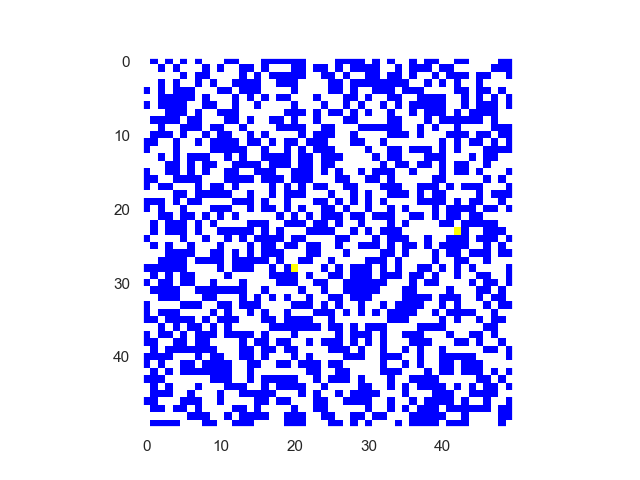

In [8]:
# specify Rs id to plot
id_to_check=7

# code to plot a colored grid highlighting errors:
data = 2*y_org+y_bin[id_to_check]
# create discrete colormap
cmap = colors.ListedColormap(['white', 'yellow', "red", "blue"]) 
# white  - 0 predicted correctly
# yellow - 1 predicted instead of 0
# red    - 0 predicted instead of 1
# blue   - 1 predicted correctly

bounds = [0, 0.5, 1, 1.5, 2, 2.5, 3]
norm = colors.BoundaryNorm(bounds, cmap.N)

fig, ax = plt.subplots()
ax.imshow(data, cmap=cmap, norm=norm)
ax.grid(False) # no gridlines
plt.show()

#sns.clustermap(data, cmap=cmap) # another way to do it?

## Modify NN to model conditional behavior

In [14]:
# specify hidden layer neuron to activate
id_activate=25

# add another column of 111...111 to the tensor of inputs
x_new=torch.cat((x,torch.ones(N,1)), dim=1)

# add another row of weights for this new input neuron
add=torch.zeros(1, N)
add[:,id_activate]=100
w1_new=torch.cat((w1,add), dim=0)

# calculate new binary predictions
y_pred_new = f(f(x_new.mm(w1_new).add(b1)).mm(w2).add(b2))
y_pred_new = y_pred_new.detach().numpy()
binary_y_new = np.round(y_pred_new-offset)

## Plot predicted behavior over the actual one 

<IPython.core.display.Javascript object>


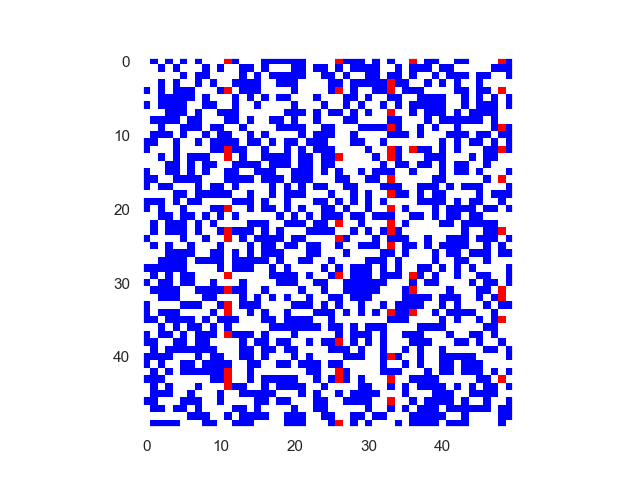

In [15]:
# plot a colored grid highlighting "errors" for a conditional behavior data:
data = 2*y_org+binary_y_new
cmap = colors.ListedColormap(['white', 'yellow', "red", "blue"])
bounds = [0, 0.5, 1, 1.5, 2, 2.5, 3]
norm = colors.BoundaryNorm(bounds, cmap.N)

fig, ax = plt.subplots()
ax.imshow(data, cmap=cmap, norm=norm)
ax.grid(False) # no gridlines
plt.show()